# Redes Neurais Recorrentes

## Teoria

* Trabalha com **dados sequências**
* Previsão de próximas ações
* Processamento de linguagem natural
    * Próxima palavra de texto
    * Tradução automática
    * Geração de poemas
    
* Legendas em vídeos
* Séries temporais (preço de ações na bolsa de valores)
    * Preço de bolsa
    * Temperatura

* "Para entender o final de uma frase, você precisa saber o que foi feito antes"
* As RN tradicionais não armazenam informações no tempo (previsões independentes)
    * RN Recorrentes possuem loops para que a informação persista no modelo (precisamos definir o número $X_t$ de células de memórias da RN)

<img src = 'Imagens/RN_Recorrente.png' width = '720'>

* Cada camada será somente um único nó, mas cada nó representa camada que pode ter várioas neurônios, a camada escondida é geralmente representada por um único neurônio, mas que representa $n$ neurônios

* Backpropagation é usado para treinar

* Pesos são compartilhados, a memória é curta, rápida e lembra somente o que aconteceu há algumas interações

* A auto ligação é o temporal no loop

* Milhares de camadas: Os pesos são multiplicados mais vezes e estes se tornarão cada vez menores -> **GRADIENTE DESAPARENCENDO: VANISH GRADIENT**. Soluções
    * BackPropagationThroughtTime (**BPTT**): Algoritmo semelhante que também fluirá para trás a partir do tempo futuro para os tempos atuais
    * Xavier Initialization
    * **LSTM** (Long Short Term Memory): Tipo especial de RN Recorrente

* Exploding Gradient: Valor de gradiente ficará muito grande (não irá encontrar o mínimo global). Soluções
    * Não visitar todas as camadas ocultas 
    * RMSProp: Divide a taxa de aprendizagem por uma média exponencialmente decrescente do quadrado do gradiente
    * Clipping do Gradiente (Grampo/Limite superior)

$\large{\textbf{LSTM}}$

* RN recorrentes simples não conseguem ter memórias longas para entender certos contextos
    * Dependências de longo prazo 
* Células de memória evitam os problemas do gradiente 
    * Forget gate: Liberar da memória
    * Input gate: adicionar na memória
    * Output gate: ler da memória

**Passo a passo**:
1. Decide o que será apagado da memória (função de ativação 1 : sigmoide)
2. Decide o que será armazenado: Quais valores serão alterados e a função de tangente hiperbólica cria um vetor dos novos candidatos
3. Atualiza o estado antigo 
4. Decisão de qual será a saída: Filtro utilizando função sigmoide, retornando valores entre -1 e 1 p/ retornar somente as partes necessárias.


## Aplicação: Previsão de Valor da Petrobrás

### Importando Bibliotecas

In [35]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

### Importando Datasets

In [2]:
base = pd.read_csv('dados/dataset_petr/petr4_treinamento.csv')
base 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [3]:
base.isnull().value_counts()

Date   Open   High   Low    Close  Adj Close  Volume
False  False  False  False  False  False      False     1242
       True   True   True   True   True       True         3
dtype: int64

In [4]:
base = base.dropna()

In [6]:
base_treinamento = base.iloc[:, 1:2].values

In [8]:
base_treinamento

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [9]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_treinamento_normalizada

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

### Estrutura da base de dados para a previsão temportal

Definimos que utilizamos os 90 valores anteriores para prever o valor atual

In [10]:
previsores = []
preco_real = []
for i in range(90, len(base_treinamento_normalizada)):
    previsores.append(base_treinamento_normalizada[i - 90: i , 0])
    preco_real.append(base_treinamento_normalizada[i, 0])

In [12]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [13]:
previsores.shape

(1152, 90)

In [14]:
previsores = np.reshape(
    previsores, 
    (previsores.shape[0], previsores.shape[1], 1) # 1152, 90, 1 
)

In [15]:
previsores.shape

(1152, 90, 1)

### Estrutura da Rede Neural

In [18]:
regressor = Sequential()

regressor.add(LSTM(
    units = 100,                                # 100 Células de memória
    return_sequences = True,                    # Vai passar a informação p/ camadas subsequentes
    input_shape = (previsores.shape[1], 1)      # Tamanho de neurônios de input

))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = True
))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = True
))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = False
))
regressor.add(Dropout(0.3))

regressor.add(Dense(
    units = 1,
    activation = 'linear'
))

regressor.compile(
    optimizer = 'rmsprop',
    loss= 'mean_squared_error',
    metrics = ['mean_absolute_error']
)

In [19]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 [==============================] - 11s 27ms/step - loss: 0.0380 - mean_absolute_error: 0.1356 0s - loss: 0.0389 - mean_absolute_error: 0.137
Epoch 2/100
36/36 [==============================] - 1s 29ms/step - loss: 0.0166 - mean_absolute_error: 0.1002
Epoch 3/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0142 - mean_absolute_error: 0.0904
Epoch 4/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0125 - mean_absolute_error: 0.0855
Epoch 5/100
36/36 [==============================] - 1s 34ms/step - loss: 0.0102 - mean_absolute_error: 0.0788
Epoch 6/100
36/36 [==============================] - 1s 35ms/step - loss: 0.0096 - mean_absolute_error: 0.0740
Epoch 7/100
36/36 [==============================] - 1s 34ms/step - loss: 0.0085 - mean_absolute_error: 0.0719
Epoch 8/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0087 - mean_absolute_error: 0.0699
Epoch 9/100
36/36 [==============================] - 1s 33ms/ste

### Previsões

In [20]:
base_teste = pd.read_csv('dados/dataset_petr/petr4_teste.csv')

In [21]:
preco_real_teste = base_teste.iloc[: , 1:2].values

In [23]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
base_completa

0     19.990000
1     19.809999
2     20.330000
3     20.480000
4     20.110001
        ...    
17    19.340000
18    19.620001
19    19.670000
20    19.770000
21    19.740000
Name: Open, Length: 1264, dtype: float64

In [24]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90 : ].values
entradas

array([13.93    , 13.76    , 13.79    , 13.53    , 13.85    , 13.96    ,
       14.57    , 14.65    , 15.02    , 15.1     , 14.88    , 14.98    ,
       14.94    , 15.03    , 15.07    , 15.02    , 15.1     , 15.25    ,
       15.85    , 15.6     , 15.79    , 15.86    , 15.7     , 15.37    ,
       15.5     , 15.19    , 15.6     , 15.9     , 15.88    , 15.66    ,
       15.61    , 16.129999, 16.17    , 16.08    , 16.23    , 16.16    ,
       16.139999, 16.219999, 16.      , 16.190001, 16.290001, 16.290001,
       16.530001, 16.780001, 16.77    , 16.969999, 16.9     , 16.99    ,
       16.9     , 16.959999, 17.049999, 17.309999, 16.690001, 16.889999,
       16.709999, 16.690001, 16.639999, 15.35    , 15.62    , 15.92    ,
       16.02    , 16.15    , 16.09    , 15.98    , 16.25    , 16.01    ,
       15.93    , 15.87    , 15.3     , 15.34    , 15.65    , 15.5     ,
       15.22    , 15.3     , 15.51    , 15.48    , 15.36    , 15.65    ,
       15.1     , 15.05    , 15.16    , 15.18    , 

In [25]:
entradas = entradas.reshape(-1, 1)
entradas

array([[13.93    ],
       [13.76    ],
       [13.79    ],
       [13.53    ],
       [13.85    ],
       [13.96    ],
       [14.57    ],
       [14.65    ],
       [15.02    ],
       [15.1     ],
       [14.88    ],
       [14.98    ],
       [14.94    ],
       [15.03    ],
       [15.07    ],
       [15.02    ],
       [15.1     ],
       [15.25    ],
       [15.85    ],
       [15.6     ],
       [15.79    ],
       [15.86    ],
       [15.7     ],
       [15.37    ],
       [15.5     ],
       [15.19    ],
       [15.6     ],
       [15.9     ],
       [15.88    ],
       [15.66    ],
       [15.61    ],
       [16.129999],
       [16.17    ],
       [16.08    ],
       [16.23    ],
       [16.16    ],
       [16.139999],
       [16.219999],
       [16.      ],
       [16.190001],
       [16.290001],
       [16.290001],
       [16.530001],
       [16.780001],
       [16.77    ],
       [16.969999],
       [16.9     ],
       [16.99    ],
       [16.9     ],
       [16.959999],


In [26]:
entradas = normalizador.transform(entradas)

In [30]:
X_teste = []

for i in range(90,112):
    X_teste.append(entradas[i-90: i, 0])

X_teste = np.array(X_teste)
X_teste

array([[0.47141473, 0.46317829, 0.46463178, ..., 0.57122093, 0.57655039,
        0.57655039],
       [0.46317829, 0.46463178, 0.45203488, ..., 0.57655039, 0.57655039,
        0.5809109 ],
       [0.46463178, 0.45203488, 0.46753876, ..., 0.57655039, 0.5809109 ,
        0.59544574],
       ...,
       [0.55232558, 0.56153101, 0.56492248, ..., 0.68895349, 0.73352713,
        0.74709307],
       [0.56153101, 0.56492248, 0.55717054, ..., 0.73352713, 0.74709307,
        0.7495155 ],
       [0.56492248, 0.55717054, 0.54118217, ..., 0.74709307, 0.7495155 ,
        0.75436047]])

In [31]:
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [32]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)
previsoes 

array([[15.836709 ],
       [15.8811865],
       [16.09887  ],
       [16.39387  ],
       [16.430916 ],
       [16.410616 ],
       [16.606344 ],
       [16.644892 ],
       [16.581182 ],
       [16.657785 ],
       [16.905193 ],
       [17.018274 ],
       [17.391731 ],
       [17.848173 ],
       [17.93161  ],
       [17.845648 ],
       [17.916872 ],
       [17.994925 ],
       [18.647427 ],
       [19.090057 ],
       [19.137865 ],
       [19.165264 ]], dtype=float32)

In [33]:
previsoes.mean()

17.292519

In [34]:
preco_real_teste.mean()

17.87454563636364

### Visualizando as previsões

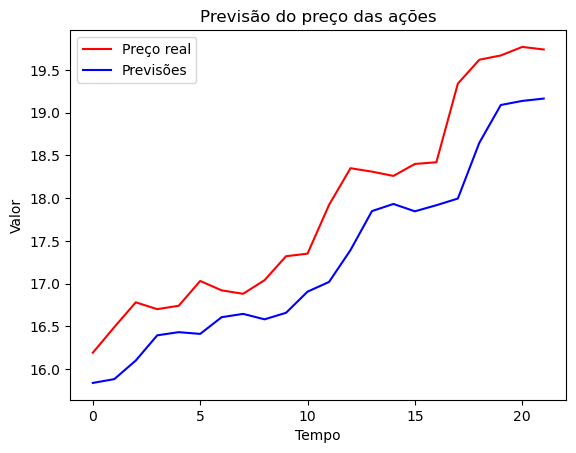

In [37]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title("Previsão do preço das ações")
plt.ylabel('Valor')
plt.xlabel('Tempo')
plt.legend()
plt.show()

## Aplicação II: Previsão da bolsa com múltiplos previsores

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base = pd.read_csv('dados/dataset_petr/petr4_treinamento.csv')
base = base.dropna()

In [3]:
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [4]:
base_treinamento = base.iloc[:, 1:7].values

In [5]:
normalizador = MinMaxScaler(feature_range= (0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [6]:
base_treinamento_normalizada

array([[0.76501938, 0.77266112, 0.79682707, 0.76080559, 0.6838135 ,
        0.04318274],
       [0.7562984 , 0.78187106, 0.79733884, 0.79567784, 0.71590949,
        0.0437121 ],
       [0.78149225, 0.79253519, 0.82139202, 0.79715132, 0.71726583,
        0.05170752],
       ...,
       [0.57122093, 0.57537562, 0.60696008, 0.58202356, 0.58202349,
        0.03369652],
       [0.57655039, 0.57489089, 0.60798362, 0.5844794 , 0.58447937,
        0.02720006],
       [0.57655039, 0.57343674, 0.61310133, 0.5844794 , 0.58447937,
        0.        ]])

In [8]:
previsores = []
preco_real = []

for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90: i, 0:6])
    preco_real.append(base_treinamento_normalizada[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [23]:
regressor = Sequential()

regressor.add(LSTM(
    units = 100,                                # 100 Células de memória
    return_sequences = True,                    # Vai passar a informação p/ camadas subsequentes
    input_shape = (previsores.shape[1], 6)      # Tamanho de neurônios de input

))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = True
))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = True
))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
))
regressor.add(Dropout(0.3))

regressor.add(Dense(
    units = 1,
    activation = 'sigmoid'
))

regressor.compile(
    optimizer = 'adam',
    loss= 'mean_squared_error',
    metrics = ['mean_absolute_error']
)

es = EarlyStopping(
    monitor= 'loss',        # Definimos parâmetro como loss
    min_delta= 1e-10,       # Diferença do loss
    patience= 10,           # 10 épocas sem melhora, paramos
    verbose= 0
)

rlr = ReduceLROnPlateau(            # Redução do learning rate quando algum parametro foi alcancado
    monitor= 'loss',
    factor= 0.2,
    patience= 5,
    verbose= 1
)

mcp = ModelCheckpoint(
    filepath = 'modelos\pesos.h5',
    monitor = 'loss',
    save_best_only= True,
    verbose= 1
)

In [24]:
regressor.fit(
    previsores, 
    preco_real, 
    epochs = 100, 
    batch_size = 32,
    callbacks = [es, rlr, mcp]
)

Epoch 1/100
36/36 [==============================] - 7s 27ms/step - loss: 0.0168 - mean_absolute_error: 0.0961

Epoch 00001: loss improved from inf to 0.01678, saving model to modelos\pesos.h5
Epoch 2/100
36/36 [==============================] - 1s 26ms/step - loss: 0.0056 - mean_absolute_error: 0.0592: 0s - loss: 0.0063 - mean_absolute_er

Epoch 00002: loss improved from 0.01678 to 0.00557, saving model to modelos\pesos.h5
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.0042 - mean_absolute_error: 0.0499

Epoch 00003: loss improved from 0.00557 to 0.00415, saving model to modelos\pesos.h5
Epoch 4/100
36/36 [==============================] - 1s 31ms/step - loss: 0.0043 - mean_absolute_error: 0.0504: 0s - loss: 0.0042 - mean_absolute_error: 0.050

Epoch 00004: loss did not improve from 0.00415
Epoch 5/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0039 - mean_absolute_error: 0.0485

Epoch 00005: loss improved from 0.00415 to 0.00393, savi

In [25]:
base_teste = pd.read_csv('dados/dataset_petr/petr4_teste.csv')

In [26]:
preco_real_teste = base_teste.iloc[:, 1:2].values
frames = [base, base_teste]

base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis = 1)

In [27]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90 :].values 
entradas = normalizador.transform(entradas)

In [28]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])

X_teste = np.array(X_teste)

In [31]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [32]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [33]:
previsoes

array([[16.211136],
       [16.288939],
       [16.419199],
       [16.600828],
       [16.778217],
       [16.923288],
       [17.038815],
       [17.088644],
       [17.111263],
       [17.154325],
       [17.232906],
       [17.371727],
       [17.640497],
       [17.984175],
       [18.277498],
       [18.455875],
       [18.495687],
       [18.58432 ],
       [18.796158],
       [19.147743],
       [19.522715],
       [19.738594]], dtype=float32)

In [34]:
previsoes.mean()

17.67557

In [35]:
preco_real_teste.mean()

17.87454563636364

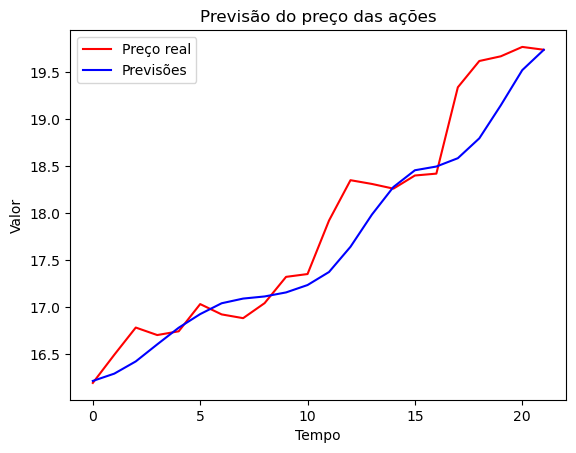

In [36]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title("Previsão do preço das ações")
plt.ylabel('Valor')
plt.xlabel('Tempo')
plt.legend()
plt.show()

## Rede Neural com Multiplas saídas

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
base = pd.read_csv('dados/dataset_petr/petr4_treinamento.csv').dropna()
base 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [5]:
base_treinamento = base.iloc[:, 1:2].values
base_valor_maximo = base.iloc[:, 2:3].values

In [6]:
normalizador = MinMaxScaler(feature_range = (0,1))

In [7]:
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo)

In [8]:
previsores = []
preco_real1 = []
preco_real2 = []

for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real1.append(base_treinamento_normalizada[i, 0])
    preco_real2.append(base_valor_maximo_normalizada[i, 0])

previsores, preco_real1, preco_real2 = np.array(previsores), np.array(preco_real1), np.array(preco_real2)

previsores = np.reshape(
    previsores,
    (previsores.shape[0], previsores.shape[1], 1)
)

preco_real = np.column_stack(
    (preco_real1, preco_real2)
)

In [10]:
regressor = Sequential()

regressor.add(LSTM(
    units = 100,                                # 100 Células de memória
    return_sequences = True,                    # Vai passar a informação p/ camadas subsequentes
    input_shape = (previsores.shape[1], 1)      # Tamanho de neurônios de input

))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = True
))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = True
))
regressor.add(Dropout(0.3))

regressor.add(LSTM(
    units = 50,
    return_sequences = False
))
regressor.add(Dropout(0.3))

regressor.add(Dense(
    units = 2,
    activation = 'linear'
))

regressor.compile(
    optimizer = 'rmsprop',
    loss= 'mean_squared_error',
    metrics = ['mean_absolute_error']
)

regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 [==============================] - 10s 37ms/step - loss: 0.0420 - mean_absolute_error: 0.1497 0s - loss: 0.0427 - mean_absolute_error: 0.150
Epoch 2/100
36/36 [==============================] - 1s 32ms/step - loss: 0.0193 - mean_absolute_error: 0.1079
Epoch 3/100
36/36 [==============================] - 1s 32ms/step - loss: 0.0175 - mean_absolute_error: 0.1024
Epoch 4/100
36/36 [==============================] - 1s 32ms/step - loss: 0.0135 - mean_absolute_error: 0.0893
Epoch 5/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0119 - mean_absolute_error: 0.0834
Epoch 6/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0121 - mean_absolute_error: 0.0836
Epoch 7/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0107 - mean_absolute_error: 0.0773
Epoch 8/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0085 - mean_absolute_error: 0.0714
Epoch 9/100
36/36 [==============================] - 1s 32ms/ste

In [14]:
base_teste = pd.read_csv('dados/dataset_petr/petr4_teste.csv')
base_teste

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000
5,2018-01-09,17.030001,17.160000,16.959999,17.030001,16.996010,35070900
6,2018-01-10,16.920000,17.049999,16.770000,16.799999,16.766466,28547700
7,2018-01-11,16.879999,17.299999,16.840000,17.250000,17.215569,37921500
8,2018-01-12,17.040001,17.410000,17.020000,17.299999,17.265469,45912100
9,2018-01-15,17.320000,17.440001,17.150000,17.350000,17.315371,28945400


In [13]:
preco_real_open = base_teste.iloc[:, 1:2].values
preco_real_hith = base_teste.iloc[:, 2:3].values

In [15]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

In [16]:
X_teste = []

for i in range(90,112):
    X_teste.append(entradas[i-90:i, 0])

X_teste = np.array(X_teste)
X_teste = np.reshape(
    X_teste, 
    (X_teste.shape[0], X_teste.shape[1], 1)
)

In [17]:
previsoes = regressor.predict(X_teste)

In [18]:
previsoes

array([[0.602921  , 0.6135918 ],
       [0.6055277 , 0.6163137 ],
       [0.6168256 , 0.6278556 ],
       [0.63211286, 0.643514  ],
       [0.63468564, 0.6462845 ],
       [0.6343393 , 0.64602584],
       [0.64465153, 0.656572  ],
       [0.64695835, 0.6590032 ],
       [0.64400077, 0.6560412 ],
       [0.6480044 , 0.6601222 ],
       [0.6606089 , 0.6729904 ],
       [0.66667604, 0.6792644 ],
       [0.6860547 , 0.6991279 ],
       [0.7100929 , 0.7238616 ],
       [0.71580017, 0.7299388 ],
       [0.7127094 , 0.7269401 ],
       [0.71694994, 0.7313434 ],
       [0.72113466, 0.7356794 ],
       [0.75415075, 0.7695396 ],
       [0.77761674, 0.79383606],
       [0.78188825, 0.79848075],
       [0.78475106, 0.8015852 ]], dtype=float32)

In [19]:
previsoes = normalizador.inverse_transform(previsoes)
previsoes

array([[16.70826 , 16.928398],
       [16.762035, 16.98455 ],
       [16.995111, 17.22266 ],
       [17.310488, 17.545692],
       [17.363564, 17.60285 ],
       [17.356419, 17.597513],
       [17.56916 , 17.815079],
       [17.61675 , 17.865236],
       [17.555735, 17.80413 ],
       [17.63833 , 17.88832 ],
       [17.898361, 18.153791],
       [18.023527, 18.283224],
       [18.423307, 18.693008],
       [18.919216, 19.203264],
       [19.036957, 19.328638],
       [18.973196, 19.266773],
       [19.060677, 19.357615],
       [19.147007, 19.447065],
       [19.828129, 20.145601],
       [20.312233, 20.64684 ],
       [20.400354, 20.742657],
       [20.459414, 20.806702]], dtype=float32)

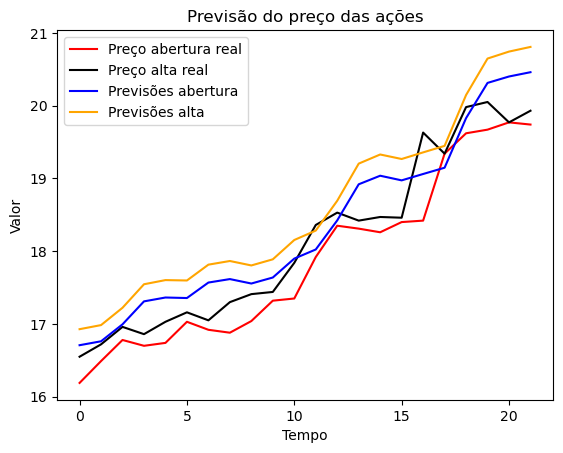

In [20]:
plt.plot(preco_real_open, color = 'red', label = 'Preço abertura real')
plt.plot(preco_real_hith, color = 'black', label = 'Preço alta real')

plt.plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
plt.plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')

plt.title("Previsão do preço das ações")
plt.ylabel('Valor')
plt.xlabel('Tempo')
plt.legend()
plt.show()